In [2]:
# GTM Package including GTM and the plot functions
from gtm import *
# Sample Copulas Package
import pyvinecopulib as pv
import numpy as np
# Other Stuff
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Sample Data

In [3]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [4]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_12679/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_12679/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_12679/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

In [5]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [6]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_12679/2452348847.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_12679/2452348847.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_12679/2452348847.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

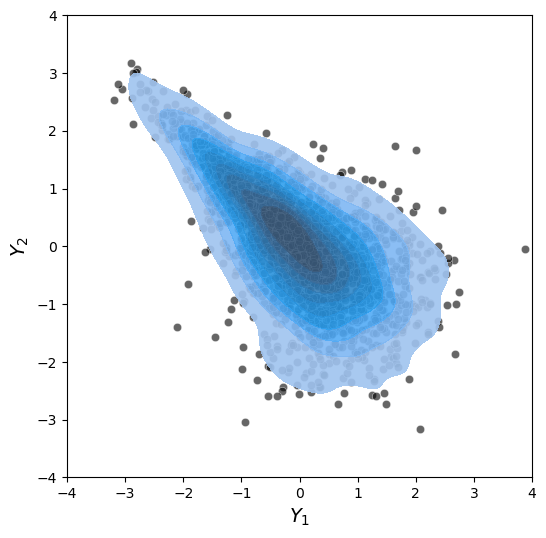

In [7]:
_ = plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

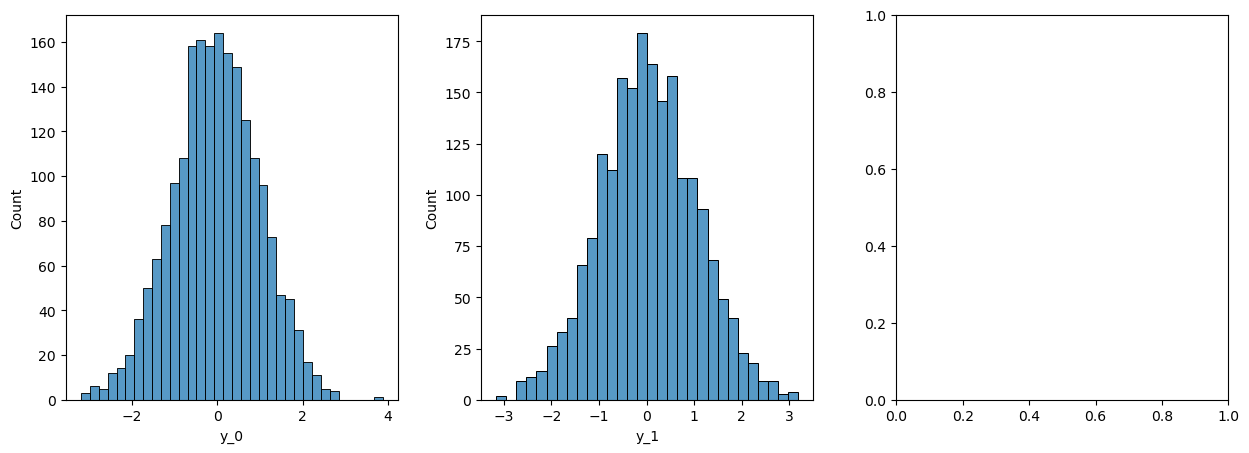

In [8]:
_ = plot_marginals(simulated_data_train)

In [9]:
class Copula_2D_Dataset(Dataset):
    def __init__(self, data):
        
        # First Dimension (N) needs to be the samples
        # Second Dimension (D) is the dimensionality of the data
        self.data = data
    
    def __len__(self):
        return self.data.size(0)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
# Create dataset and DataLoader
dataset_train = Copula_2D_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Copula_2D_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

In [10]:
# Here you can see that we load the full data, so not batches
# Model is just implemented with dataloaders because that is eeded for huge datasets in bioinformatics
data_iter = iter(dataloader_train)
sample = next(data_iter)
sample.size()

torch.Size([2000, 2])

### 2. Define Model

In [14]:
model = GTM(
    transformation_spline_range=list([[-10], [10]]), 
    decorrelation_spline_range=list([[-10], [10]]), 
    degree_decorrelation=30,
    degree_transformations=15,
    num_decorr_layers=3,
    num_trans_layers=1,
    number_variables=2,
    spline_decorrelation="bspline", #"bspline", #"bernstein",
    spline_transformation="bernstein",
    device="cpu") 

### 3. Hyperparameter Tune and Train Model

In [15]:
study = model.hyperparameter_tune_penalties( 
                                train_dataloader=dataloader_train, 
                                validate_dataloader=dataloader_validate, 
                                penvalueridge = [0], #["sample"],
                                penfirstridge = ["sample"],
                                pensecondridge = ["sample"],
                                ctm_pensecondridge = [0], #["sample"],
                                lambda_penalty_params = [0], #["sample"],
                                train_covariates=False, 
                                validate_covariates=False, 
                                adaptive_lasso_weights_matrix = False,
                                learning_rate=1, 
                                iterations=1000, 
                                patience=5, 
                                min_delta=1e-7, 
                                optimizer='LBFGS', 
                                lambda_penalty_mode="square", 
                                objective_type="negloglik", 
                                seperate_copula_training=False,
                                max_batches_per_iter=False,
                                tuning_mode="optuna",
                                cross_validation_folds=False,
                                random_state_KFold=42,
                                device=None,
                                pretrained_transformation_layer=False,
                                n_trials=10,
                                temp_folder=".", 
                                study_name=None)
    
penalty_params=torch.FloatTensor([
                            0, #study.best_params["penvalueridge"],
                            study.best_params["penfirstridge"],
                            study.best_params["pensecondridge"],
                            0 #study.best_params["ctm_pensecondridge"]
                              ])
adaptive_lasso_weights_matrix = False
lambda_penalty_params=False

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-26 16:30:27,409] A new study created in RDB with name: no-name-2cc8d16d-c840-4e6f-abf8-fcd17dd6eca3


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 7.275257236279194   pensecondridge_opt: 27.695339580007605   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  0%|          | 0/1000 [00:00<?, ?it/s]
[W 2025-05-26 16:30:27,438] Trial 0 failed with parameters: {'penfirstridge': 7.275257236279194, 'pensecondridge': 27.695339580007605} because of the following error: RuntimeError('The expanded size of the tensor (2000) must match the existing size (2) at non-singleton dimension 0.  Target sizes: [2000].  Tensor sizes: [2]').
Traceback (most recent call last):
  File "/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_model/gtm.py", line 701, in optuna_objective
    target = self.return_objective_for_hyperparameters(train_dataloader, validate_dataloader, train_covariates, validate_covariates, penalty_params_opt,
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RuntimeError: The expanded size of the tensor (2000) must match the existing size (2) at non-singleton dimension 0.  Target sizes: [2000].  Tensor sizes: [2]

In [ ]:

penalty_params = torch.tensor([ 0.0000,  1.7809, 18.6645,  0.0000])
adaptive_lasso_weights_matrix = False
lambda_penalty_params=False

In [ ]:
# pretrain the marginal transformations
_ = model.pretrain_tranformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_params=penalty_params)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_model/gtm.py:296: UserWarning: Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.
  warnings.warn("Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.")
  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: The expanded size of the tensor (2000) must match the existing size (2) at non-singleton dimension 0.  Target sizes: [2000].  Tensor sizes: [2]

In [ ]:
# train the joint model
_ = model.__train__(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_params=penalty_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, lambda_penalty_params=lambda_penalty_params, 
                max_batches_per_iter=False)

  6%|▌         | 61/1000 [00:02<00:33, 27.96it/s]


### 4. Compare Fit to Benchmarks

In [ ]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [ ]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)  # 0 to do mean across dim 0 not globally
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [ ]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.0118
KLD Gaussian Train Data:  0.1067
KLD Copula   Train Data:  -0.0001
KLD GTM      Test  Data:  0.0127
KLD Gaussian Test  Data:  0.1029
KLD Copula   Test  Data:  0.0014


KLD GTM      Train Data:  0.0113
KLD Gaussian Train Data:  0.1057
KLD Copula   Train Data:  -0.0005
KLD GTM      Test  Data:  0.0117
KLD Gaussian Test  Data:  0.1143
KLD Copula   Test  Data:  0.0009

### 5. Evaluate and Plot GTM Results

In [ ]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(2000)

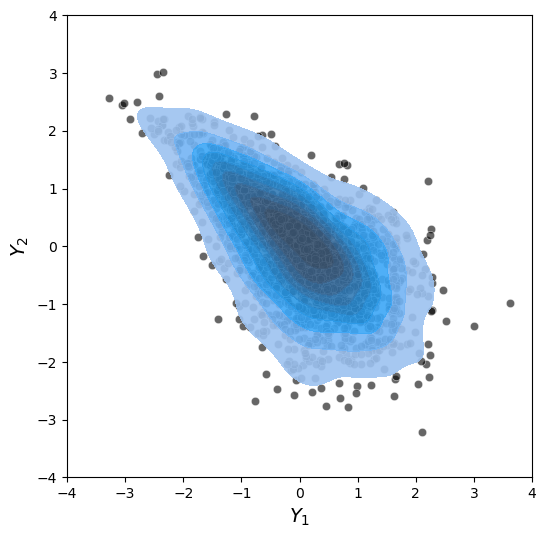

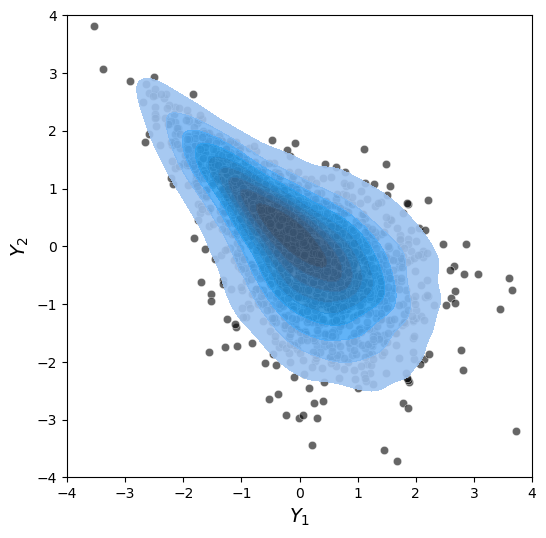

In [ ]:
_ = plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
_ = plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [ ]:
synthetic_samples = model.sample(2000)
p_matrix = model.compute_precision_matrix(synthetic_samples)

In [ ]:
conditional_correlation_matrix_train = model.compute_correlation_matrix(synthetic_samples)
conditional_correlation = conditional_correlation_matrix_train[:,0,1]

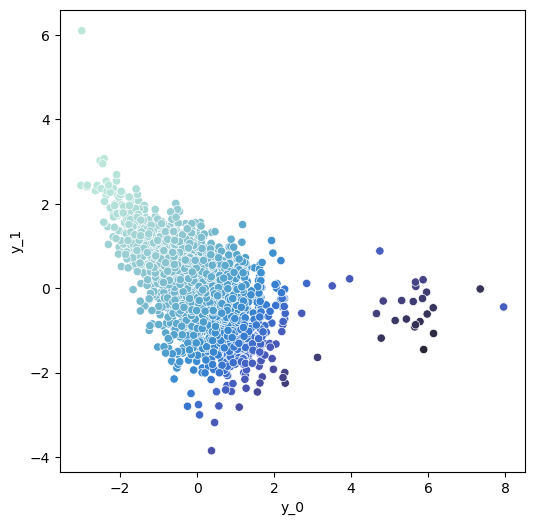

In [ ]:
_ = plot_metric_scatter(data=synthetic_samples,metric=conditional_correlation)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, spline_num],


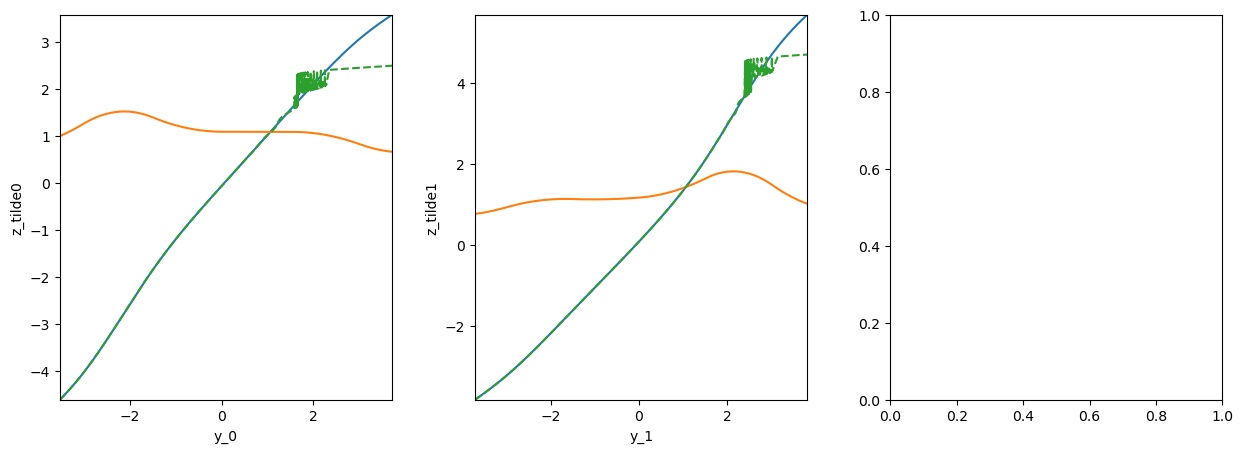

In [ ]:
_ = plot_splines(model.transformation,simulated_data_train)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


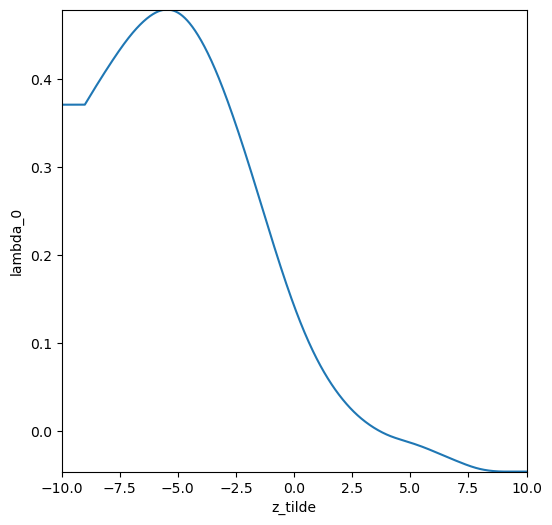

In [ ]:
_ = plot_splines(model.decorrelation_layers[0],simulated_data_train)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


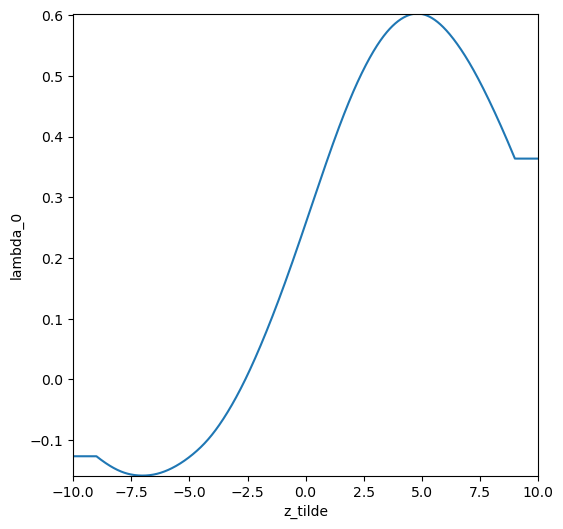

In [ ]:
_ = plot_splines(model.decorrelation_layers[1],simulated_data_train)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


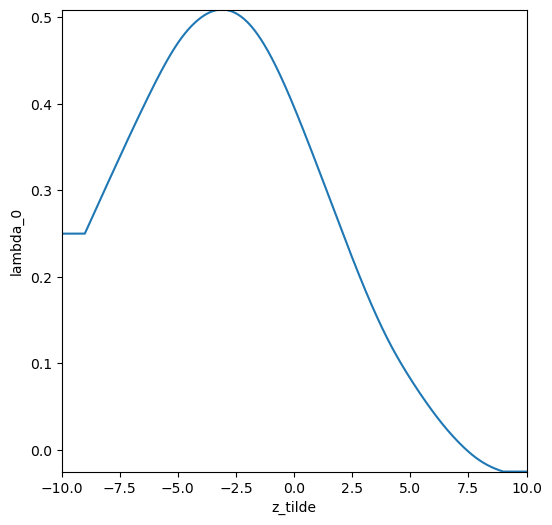

In [ ]:
_ = plot_splines(model.decorrelation_layers[2],simulated_data_train)